In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [2]:
!pip install seaborn==0.13.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import textwrap
from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve, precision_score, recall_score
from statistics import mean
from src.utils import utils, evaluation_utils, visualization_utils

In [4]:
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_idv.csv")

In [5]:
def read_output_df(output_file_paths):
    dfs = []
    for host_type, output_file_path in output_file_paths.items():
        df = pd.read_csv(output_file_path, index_col=0)
        df["host_type"] = host_type
        dfs.append(df)
    return pd.concat(dfs)


def compute_class_distribution(df, label_col, n, format=False):
    labels_counts = df[label_col].value_counts()
    print(labels_counts)
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k}\n(n={int(v/100*n)}, {v:.3f}%)" for k, v, in labels_counts.items()}
    return labels_counts

In [6]:
dataset_df = pd.read_csv(dataset_file_path)

In [7]:
metadata_formatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=True)
metadata_formatted

Homo sapiens                          218631
Macaca mulatta                           849
Felis catus                              143
Cercocebus atys                          122
Puma concolor                             24
Macaca nemestrina                         23
Mandrillus sphinx                         23
Mandrillus leucophaeus                    20
Cercopithecus nictitans                   19
Cercopithecus solatus                     17
Cercocebus torquatus                      16
Cercopithecus aethiops                    14
Cercopithecus cephus                      13
Chlorocebus sabaeus                       13
Colobus guereza                           13
Panthera leo                              12
Cercopithecus neglectus                   12
Cercopithecus mona                        10
Chlorocebus tantalus                      10
Felis silvestris catus                     9
Cercopithecus lhoesti                      8
Chlorocebus pygerythrus                    7
Cercopithe

{'Homo sapiens': 'Homo sapiens\n(n=218631, 99.347%)',
 'Macaca mulatta': 'Macaca mulatta\n(n=849, 0.386%)',
 'Felis catus': 'Felis catus\n(n=143, 0.065%)',
 'Cercocebus atys': 'Cercocebus atys\n(n=122, 0.055%)',
 'Puma concolor': 'Puma concolor\n(n=24, 0.011%)',
 'Macaca nemestrina': 'Macaca nemestrina\n(n=23, 0.010%)',
 'Mandrillus sphinx': 'Mandrillus sphinx\n(n=23, 0.010%)',
 'Mandrillus leucophaeus': 'Mandrillus leucophaeus\n(n=20, 0.009%)',
 'Cercopithecus nictitans': 'Cercopithecus nictitans\n(n=19, 0.009%)',
 'Cercopithecus solatus': 'Cercopithecus solatus\n(n=17, 0.008%)',
 'Cercocebus torquatus': 'Cercocebus torquatus\n(n=16, 0.007%)',
 'Cercopithecus aethiops': 'Cercopithecus aethiops\n(n=14, 0.006%)',
 'Cercopithecus cephus': 'Cercopithecus cephus\n(n=13, 0.006%)',
 'Chlorocebus sabaeus': 'Chlorocebus sabaeus\n(n=13, 0.006%)',
 'Colobus guereza': 'Colobus guereza\n(n=13, 0.006%)',
 'Panthera leo': 'Panthera leo\n(n=12, 0.005%)',
 'Cercopithecus neglectus': 'Cercopithecus neg

In [8]:
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=False)
metadata_unformatted

Homo sapiens                          218631
Macaca mulatta                           849
Felis catus                              143
Cercocebus atys                          122
Puma concolor                             24
Macaca nemestrina                         23
Mandrillus sphinx                         23
Mandrillus leucophaeus                    20
Cercopithecus nictitans                   19
Cercopithecus solatus                     17
Cercocebus torquatus                      16
Cercopithecus aethiops                    14
Cercopithecus cephus                      13
Chlorocebus sabaeus                       13
Colobus guereza                           13
Panthera leo                              12
Cercopithecus neglectus                   12
Cercopithecus mona                        10
Chlorocebus tantalus                      10
Felis silvestris catus                     9
Cercopithecus lhoesti                      8
Chlorocebus pygerythrus                    7
Cercopithe

{'Homo sapiens': 99.34702001199629,
 'Macaca mulatta': 0.3857898467746333,
 'Felis catus': 0.0649799152989076,
 'Cercocebus atys': 0.05543741025501209,
 'Puma concolor': 0.010905720050166313,
 'Macaca nemestrina': 0.01045131504807605,
 'Mandrillus sphinx': 0.01045131504807605,
 'Mandrillus leucophaeus': 0.009088100041805259,
 'Cercopithecus nictitans': 0.008633695039714997,
 'Cercopithecus solatus': 0.007724885035534471,
 'Cercocebus torquatus': 0.0072704800334442085,
 'Cercopithecus aethiops': 0.0063616700292636824,
 'Cercopithecus cephus': 0.005907265027173419,
 'Chlorocebus sabaeus': 0.005907265027173419,
 'Colobus guereza': 0.005907265027173419,
 'Panthera leo': 0.005452860025083156,
 'Cercopithecus neglectus': 0.005452860025083156,
 'Cercopithecus mona': 0.0045440500209026295,
 'Chlorocebus tantalus': 0.0045440500209026295,
 'Felis silvestris catus': 0.004089645018812368,
 'Cercopithecus lhoesti': 0.0036352400167221043,
 'Chlorocebus pygerythrus': 0.0031808350146318412,
 'Cercopit

In [9]:
classes = list(metadata_unformatted.keys())
classes

['Homo sapiens',
 'Macaca mulatta',
 'Felis catus',
 'Cercocebus atys',
 'Puma concolor',
 'Macaca nemestrina',
 'Mandrillus sphinx',
 'Mandrillus leucophaeus',
 'Cercopithecus nictitans',
 'Cercopithecus solatus',
 'Cercocebus torquatus',
 'Cercopithecus aethiops',
 'Cercopithecus cephus',
 'Chlorocebus sabaeus',
 'Colobus guereza',
 'Panthera leo',
 'Cercopithecus neglectus',
 'Cercopithecus mona',
 'Chlorocebus tantalus',
 'Felis silvestris catus',
 'Cercopithecus lhoesti',
 'Chlorocebus pygerythrus',
 'Cercopithecus mitis',
 'Cercopithecus erythrotis',
 'Felis domesticus',
 'Macaca arctoides',
 'Macaca fascicularis',
 'Semnopithecus entellus',
 'Bos taurus',
 'Miopithecus ogouensis',
 'Cercopithecus ascanius',
 'Cercocebus torquatus atys',
 'Lynx rufus',
 'Cercopithecus aethiops pygerythrus',
 'Piliocolobus tephrosceles',
 'Piliocolobus badius',
 'Otocolobus manul',
 'Panthera pardus',
 'Papio ursinus',
 'Procolobus verus']

In [10]:
classes_order = {k:i for i, k in enumerate(classes)}
classes_order

{'Homo sapiens': 0,
 'Macaca mulatta': 1,
 'Felis catus': 2,
 'Cercocebus atys': 3,
 'Puma concolor': 4,
 'Macaca nemestrina': 5,
 'Mandrillus sphinx': 6,
 'Mandrillus leucophaeus': 7,
 'Cercopithecus nictitans': 8,
 'Cercopithecus solatus': 9,
 'Cercocebus torquatus': 10,
 'Cercopithecus aethiops': 11,
 'Cercopithecus cephus': 12,
 'Chlorocebus sabaeus': 13,
 'Colobus guereza': 14,
 'Panthera leo': 15,
 'Cercopithecus neglectus': 16,
 'Cercopithecus mona': 17,
 'Chlorocebus tantalus': 18,
 'Felis silvestris catus': 19,
 'Cercopithecus lhoesti': 20,
 'Chlorocebus pygerythrus': 21,
 'Cercopithecus mitis': 22,
 'Cercopithecus erythrotis': 23,
 'Felis domesticus': 24,
 'Macaca arctoides': 25,
 'Macaca fascicularis': 26,
 'Semnopithecus entellus': 27,
 'Bos taurus': 28,
 'Miopithecus ogouensis': 29,
 'Cercopithecus ascanius': 30,
 'Cercocebus torquatus atys': 31,
 'Lynx rufus': 32,
 'Cercopithecus aethiops pygerythrus': 33,
 'Piliocolobus tephrosceles': 34,
 'Piliocolobus badius': 35,
 'Ot

In [11]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

### Seen Hosts

#### 148-way, AUPRC and Precision

In [12]:
output_filepath =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_seen_hosts/20241003/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk10e1b32itr1_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
auprc_filepath =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_seen_hosts/20241003/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk10e1b32itr1_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")

In [13]:
output_auprc_df = pd.read_csv(auprc_filepath, index_col=0)
print(output_auprc_df["class"].nunique())
output_df = pd.read_csv(output_filepath, index_col=0)
output_df

148


,Acanthorhynchus tenuirostris,Acinonyx jubatus,Aegithalos caudatus,Ailuropoda melanoleuca,Ailurus fulgens,Alces alces,Amazona oratrix,Ambystoma tigrinum,Anas castanea,Anas gracilis,...,Turdus hortulorum,Turdus naumanni,Turdus pallidus,Tursiops aduncus,Tursiops truncatus,Vespertilio sinensis,Vulpes vulpes,Zoothera dauma,y_true,itr
0,0.000977,0.000174,0.000658,0.000279,0.000408,0.000030,0.001073,0.001157,0.012598,0.000638,...,0.000215,0.000453,0.000236,4.165386e-04,0.080606,0.002512,0.001648,0.000099,Bos taurus,0
1,0.000434,0.002168,0.002019,0.000630,0.002974,0.000427,0.001941,0.000283,0.008158,0.002817,...,0.000395,0.000653,0.000624,4.519798e-03,0.018131,0.003450,0.002683,0.001439,Bos taurus,0
2,0.001190,0.000751,0.000786,0.000353,0.001226,0.000207,0.001875,0.001114,0.008722,0.001491,...,0.000216,0.000300,0.000308,2.896630e-03,0.017882,0.003724,0.001246,0.000700,Bos taurus,0
3,0.000605,0.000753,0.005345,0.003273,0.009737,0.001056,0.005360,0.000204,0.015742,0.009556,...,0.009369,0.004400,0.003679,7.867229e-04,0.003427,0.001849,0.010433,0.000739,Bos taurus,0
4,0.002413,0.000086,0.000307,0.000231,0.000344,0.000057,0.000940,0.002173,0.014737,0.000677,...,0.000148,0.000272,0.000206,3.669839e-04,0.068541,0.002771,0.000993,0.000127,Felis catus,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196645,0.027532,0.001668,0.000574,0.000884,0.001690,0.000026,0.005971,0.006258,0.002716,0.003524,...,0.000406,0.000631,0.000700,9.961659e-07,0.023588,0.003261,0.000964,0.000067,Mandrillus sphinx,0
2196646,0.000514,0.004215,0.003404,0.001337,0.004493,0.000147,0.013786,0.000664,0.017250,0.007359,...,0.001714,0.005182,0.001243,1.767406e-05,0.016332,0.003500,0.009599,0.000647,Mandrillus sphinx,0
2196647,0.000025,0.000733,0.008317,0.000579,0.001257,0.000058,0.003546,0.000053,0.031623,0.002786,...,0.001043,0.007736,0.000413,9.038871e-05,0.002814,0.000319,0.008465,0.000308,Mandrillus sphinx,0
2196648,0.000282,0.008142,0.005249,0.001065,0.002771,0.000227,0.007147,0.000796,0.029317,0.004609,...,0.001925,0.009074,0.001271,9.497865e-05,0.008983,0.002277,0.010405,0.000739,Mandrillus sphinx,0


In [14]:
all_output_labels = list(output_df.columns)
all_output_labels.remove("itr")
all_output_labels.remove("y_true")
print(len(all_output_labels))

148


In [15]:
# Get the label with the maximum probability
output_df["y_pred"] = output_df[all_output_labels].idxmax(axis=1)
output_df["y_pred_prob"] = output_df[all_output_labels].max(axis=1)

In [16]:
dataset_df["virus_host_name"].nunique()

40

In [17]:
labels_present_in_output = set(metadata_unformatted.keys()).intersection(set(all_output_labels))
print(len(labels_present_in_output))
labels_present_in_output

8


{'Bos taurus',
 'Felis catus',
 'Felis domesticus',
 'Homo sapiens',
 'Macaca arctoides',
 'Macaca fascicularis',
 'Macaca mulatta',
 'Mandrillus sphinx'}

In [ ]:
# compute_metrics
metrics = []
for label in labels_present_in_output:
    precision = precision_score(y_true = output_df["y_true"].values, y_pred = output_df["y_pred"].values, labels=[label], average=None)
    recall = recall_score(y_true = output_df["y_true"].values, y_pred = output_df["y_pred"].values, labels=[label], average=None)
    metrics.append({
        "class": label,
        "precision": precision[0],
        "recall": recall[0]
    })

metrics_df = pd.DataFrame(metrics)
metrics_df

<Figure size 432x288 with 0 Axes>

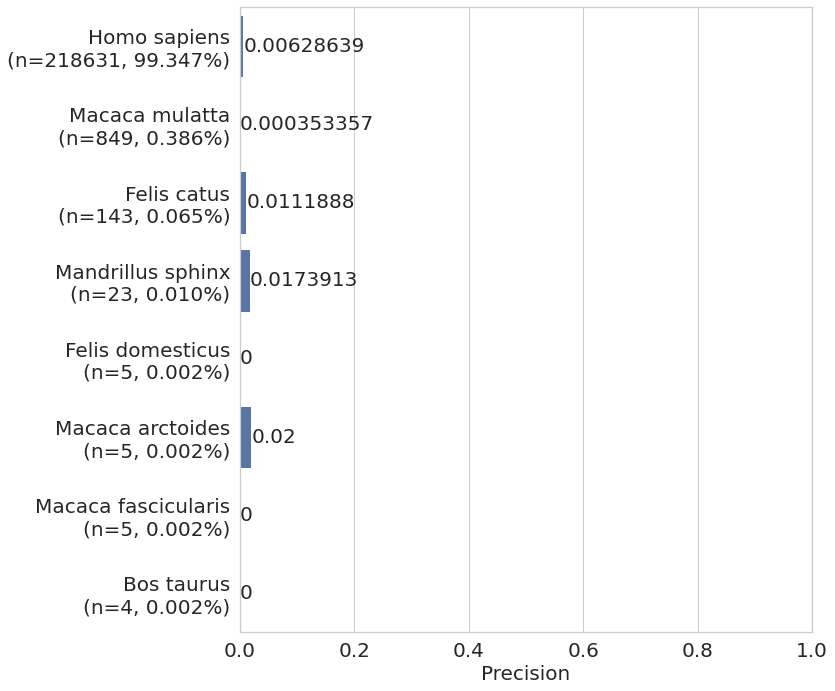

In [58]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(12, 10), sharex=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

metrics_df.sort_values(by=["class"], key=lambda x: x.map(classes_order), inplace=True)
formatted_df = metrics_df.replace({"class": metadata_formatted})
classes = list(formatted_df["class"].unique())
bins = get_uniformly_divided_position_bins(list(classes), 1)
for i in range(1):    
    sns.barplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="recall", y="class", ax=axs, orient="h", order=bins[i]) #color="black", alpha=.7, s=5)
    axs.bar_label(axs.containers[0], fontsize=20);

    axs.set_ylabel("")
    axs.set_xlabel("Precision", fontsize=20)
    axs.set_xlim(0, 1)


plt.tight_layout(pad=.1)
plt.show()

In [22]:
output_df

,Acanthorhynchus tenuirostris,Acinonyx jubatus,Aegithalos caudatus,Ailuropoda melanoleuca,Ailurus fulgens,Alces alces,Amazona oratrix,Ambystoma tigrinum,Anas castanea,Anas gracilis,...,Turdus pallidus,Tursiops aduncus,Tursiops truncatus,Vespertilio sinensis,Vulpes vulpes,Zoothera dauma,y_true,itr,y_pred,y_pred_prob
0,0.000977,0.000174,0.000658,0.000279,0.000408,0.000030,0.001073,0.001157,0.012598,0.000638,...,0.000236,4.165386e-04,0.080606,0.002512,0.001648,0.000099,Bos taurus,0,Suncus murinus,0.103063
1,0.000434,0.002168,0.002019,0.000630,0.002974,0.000427,0.001941,0.000283,0.008158,0.002817,...,0.000624,4.519798e-03,0.018131,0.003450,0.002683,0.001439,Bos taurus,0,Rousettus aegyptiacus,0.048067
2,0.001190,0.000751,0.000786,0.000353,0.001226,0.000207,0.001875,0.001114,0.008722,0.001491,...,0.000308,2.896630e-03,0.017882,0.003724,0.001246,0.000700,Bos taurus,0,Pipistrellus pipistrellus,0.078152
3,0.000605,0.000753,0.005345,0.003273,0.009737,0.001056,0.005360,0.000204,0.015742,0.009556,...,0.003679,7.867229e-04,0.003427,0.001849,0.010433,0.000739,Bos taurus,0,Chenonetta jubata,0.144220
4,0.002413,0.000086,0.000307,0.000231,0.000344,0.000057,0.000940,0.002173,0.014737,0.000677,...,0.000206,3.669839e-04,0.068541,0.002771,0.000993,0.000127,Felis catus,0,Capra hircus,0.104175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196645,0.027532,0.001668,0.000574,0.000884,0.001690,0.000026,0.005971,0.006258,0.002716,0.003524,...,0.000700,9.961659e-07,0.023588,0.003261,0.000964,0.000067,Mandrillus sphinx,0,Kryptopterus bicirrhis,0.172542
2196646,0.000514,0.004215,0.003404,0.001337,0.004493,0.000147,0.013786,0.000664,0.017250,0.007359,...,0.001243,1.767406e-05,0.016332,0.003500,0.009599,0.000647,Mandrillus sphinx,0,Myodes glareolus,0.049035
2196647,0.000025,0.000733,0.008317,0.000579,0.001257,0.000058,0.003546,0.000053,0.031623,0.002786,...,0.000413,9.038871e-05,0.002814,0.000319,0.008465,0.000308,Mandrillus sphinx,0,Arctocephalus tropicalis,0.061266
2196648,0.000282,0.008142,0.005249,0.001065,0.002771,0.000227,0.007147,0.000796,0.029317,0.004609,...,0.001271,9.497865e-05,0.008983,0.002277,0.010405,0.000739,Mandrillus sphinx,0,Rousettus leschenaultii,0.035568


In [29]:
classwise_prob_dfs = []
for label in labels_present_in_output:
    sub_df = output_df[[label, "y_true"]][output_df["y_true"] == label]
    sub_df = sub_df.rename(columns={label: "prob", "y_true": "class"})
    classwise_prob_dfs.append(sub_df)
class_prob_df = pd.concat(classwise_prob_dfs)
class_prob_df

,prob,class
219642,0.022490,Mandrillus sphinx
219643,0.030742,Mandrillus sphinx
219644,0.010683,Mandrillus sphinx
219645,0.007719,Mandrillus sphinx
219646,0.014130,Mandrillus sphinx
...,...,...
2196622,0.003753,Macaca mulatta
2196623,0.002493,Macaca mulatta
2196624,0.006197,Macaca mulatta
2196625,0.005851,Macaca mulatta


In [30]:
plot_df = output_df[all_output_labels + ["y_true"]].groupby("y_true").agg("mean")
plot_df.shape
plot_df.transpose().shape

(148, 8)

<AxesSubplot:ylabel='y_true'>

<Figure size 432x288 with 0 Axes>

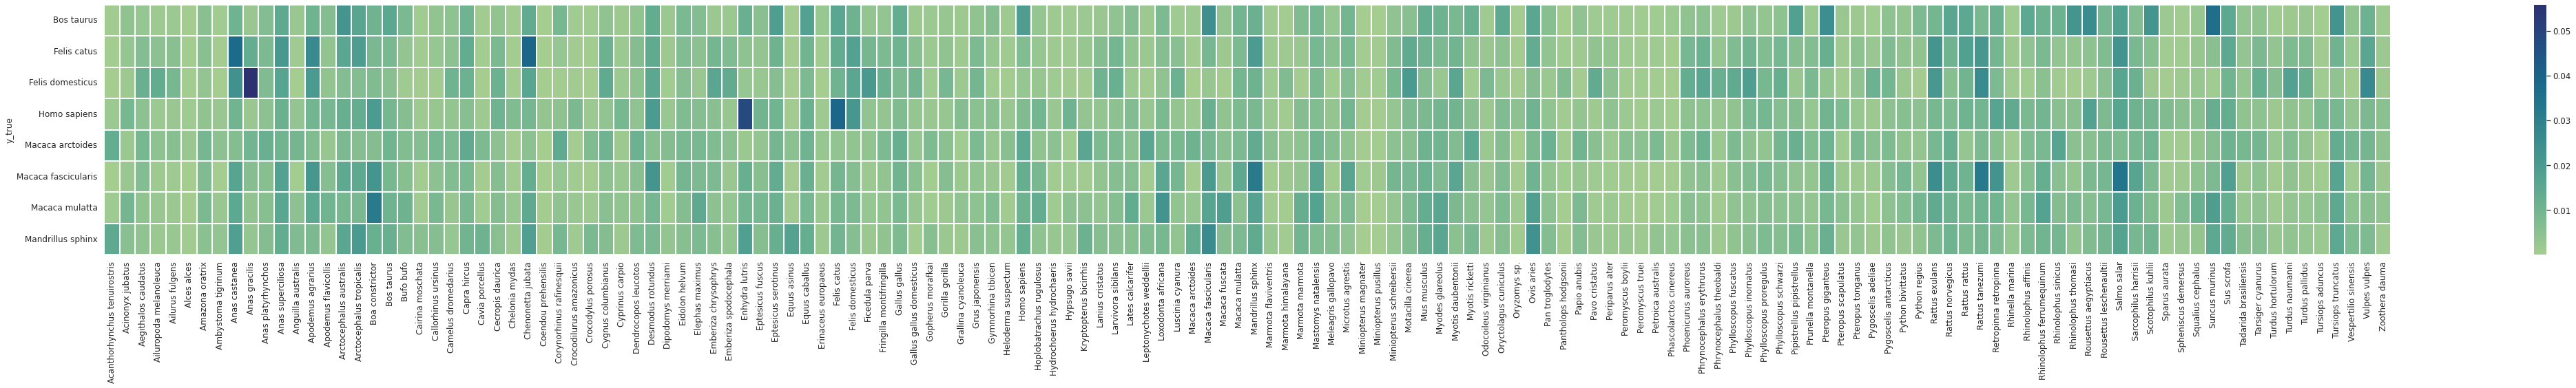

In [49]:
plt.clf()
plt.figure(figsize=(60, 8))
sns.set_theme()
sns.set_style("whitegrid")
sns.color_palette("colorblind", as_cmap=True)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

sns.heatmap(plot_df, linewidth=.05, cmap="crest")

In [76]:
plot_df.stack().reset_index()
stack_df = plot_df.stack().reset_index()
stack_df.rename(columns={"level_1": "class", 0: "prob"}, inplace=True)
stack_df.columns

Index(['y_true', 'class', 'prob'], dtype='object')

In [ ]:
output_df[all_output_labels + ["y_true"]].stack().reset_index()

<Figure size 432x288 with 0 Axes>

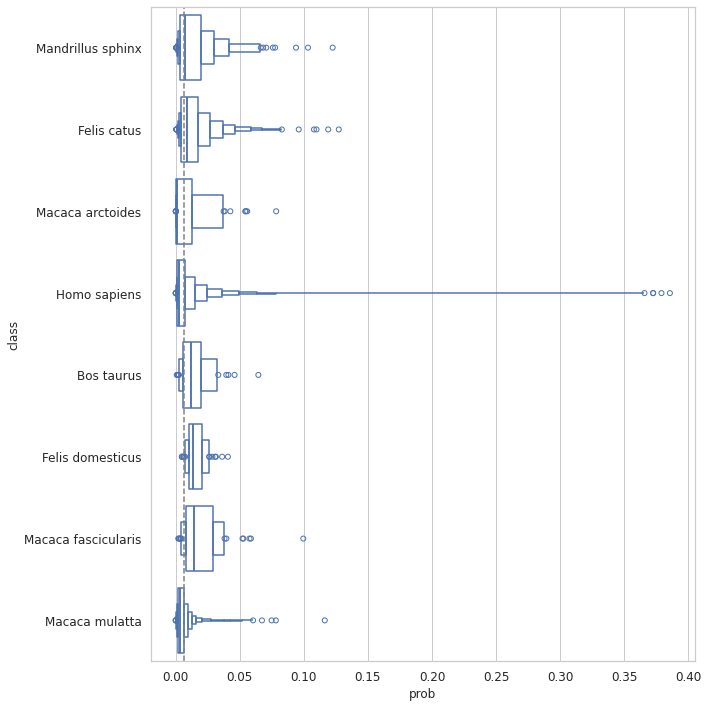

In [36]:
plt.clf()
plt.figure(figsize=(10, 10))
sns.set_theme()
sns.set_style("whitegrid")
sns.color_palette("colorblind", as_cmap=True)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

ax = sns.boxenplot(class_prob_df, x="prob", y="class", orient="h", fill=None)
#sns.swarmplot(class_prob_df[class_prob_df["class"] != "Homo sapiens"], x="prob", y="class", color="k", size=1, ax=ax, orient="h")
ax.axvline(1/148, color="gray", linestyle="--")

<Figure size 432x288 with 0 Axes>

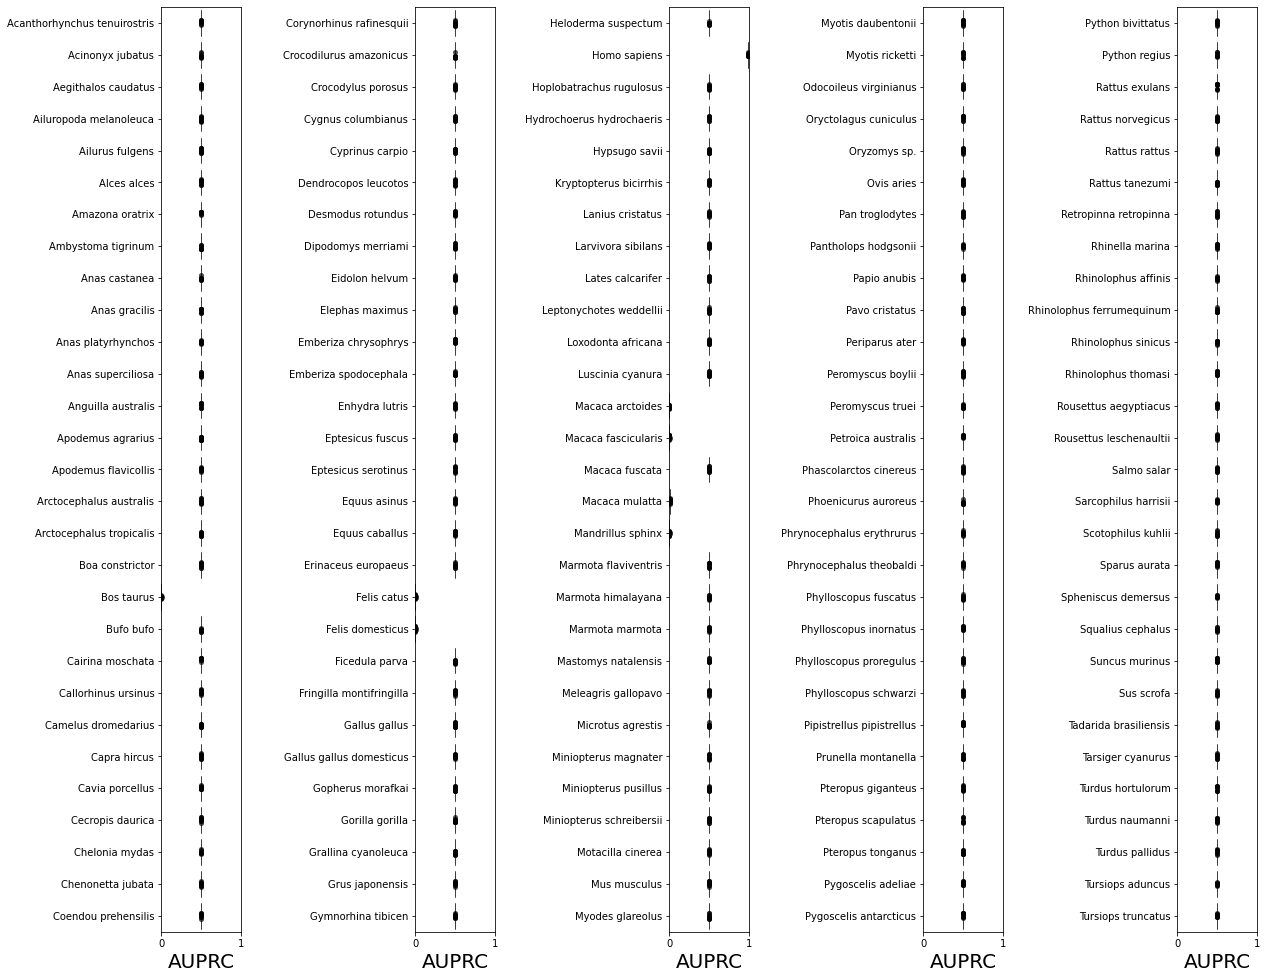

In [14]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 5, figsize=(18, 14), sharex=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

output_auprc_df.sort_values(by=["class"], key=lambda x: x.map(classes_order), inplace=True)
formatted_df = output_auprc_df.replace({"class": metadata_formatted})
classes = list(formatted_df["class"].unique())
bins = get_uniformly_divided_position_bins(list(classes), 5)
for i in range(5):
    #sns.violinplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h",  order=bins[i], fill=False,)
    #sns.barplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h", linewidth=3, fill=False, fliersize=2.5, order=bins[i])
    sns.boxplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs[i], orient="h", order=bins[i]) #color="black", alpha=.7, s=5)
    
    sns.stripplot(data=formatted_df[formatted_df["class"].isin(bins[i])], x="auprc", y="class", ax=axs[i], orient="h", color="black", alpha=.7, s=5, order=bins[i])
    #plt.draw()

    axs[i].set_ylabel("")
    axs[i].set_xlabel("AUPRC", fontsize=20)
    axs[i].set_xlim(0, 1)
#     axs.xaxis.set_major_locator(ticker.MultipleLocator(.1))
#     axs.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.tight_layout(pad=.1)
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_idv_seen_hosts_classwise_auprc_boxplot.pdf"))
plt.show()

### Unseen Hosts

In [15]:
output_df = pd.read_csv(virprobert_unseen_host_output_filepath, index_col=0)
dataset_df = pd.read_csv(dataset_file_path)

NameError: name 'virprobert_unseen_host_output_filepath' is not defined

In [ ]:
output_df

In [ ]:
metrics_df["class"].nunique()

In [ ]:
metrics_df["prevalence"] = metrics_df["class"].apply(lambda x: metadata_unformatted[x])
metrics_df

In [ ]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(18, 14), sharex=True)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams.update({'font.size': 20})



metrics_df.sort_values(by=["class"], key=lambda x: x.map(classes_order), inplace=True)
formatted_df = metrics_df.replace({"class": metadata_formatted})
classes = list(formatted_df["class"].unique())
bins = get_uniformly_divided_position_bins(list(classes), 1)
for i in range(1):
    #sns.violinplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h",  order=bins[i], fill=False,)
    #sns.barplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h", linewidth=3, fill=False, fliersize=2.5, order=bins[i])
    sns.barplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="precision", y="class", ax=axs, orient="h", order=bins[i]) #color="black", alpha=.7, s=5)
    axs.bar_label(axs.containers[0], fontsize=20);
    #sns.stripplot(data=formatted_df[formatted_df["class"].isin(bins[i])], x="auprc", y="class", ax=axs[i], orient="h", color="black", order=bins[i])
    #plt.draw()

    axs.set_ylabel("")
    axs.set_xlabel("Precision", fontsize=20)
    axs.set_xlim(0, 1)
    axs.xaxis.set_major_locator(ticker.MultipleLocator(.1))
    axs.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.tight_layout(pad=.1)
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_idv_w_non_idv_wo_human_classwise_boxplot.pdf"))
plt.show()

In [ ]:
plt.clf()
plt.figure(figsize=(8,8))
plt.rcParams["figure.autolayout"] = True
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams.update({'font.size': 18})

ax = sns.jointplot(data=formatted_df, x="prevalence", y="precision",
                   height=10, ylim=(0, 1),  xlim=(0, .1),
                   ratio=2, legend=False, marginal_ticks=True)
ax.plot_joint(sns.scatterplot, alpha=1, s=100, legend=False)
ax.plot_marginals(sns.histplot, kde=True, fill=False, color="0.2", line_kws={"color": "black", "lw": 3, "ls": "-"})
# ax = sns.scatterplot(mean_auprc_df, x="prevalance", y="auprc", hue="model", alpha=1)
ax.ax_joint.set_xlabel("Class Prevalence (%)")
ax.ax_joint.set_ylabel("Precision")
ax.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(.02))
ax.ax_joint.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(.1))
ax.ax_joint.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax = plt.gca()
#ax.legend()
ax.figure.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_idv_precision_scatterplot_w_hist.pdf"))
plt.show()